[Table of Contents](./table_of_contents.ipynb)

# Multivariate Gaussians

Modeling Uncertainty in Multiple Dimensions

In [62]:
%matplotlib inline

In [63]:
#format the book
import book_format
book_format.set_style()

## Introduction

The techniques in the last chapter are very powerful, but they only work with one variable or dimension. They provide no way to represent multidimensional data, such as the position and velocity of a dog in a field. Position and velocity are related to each other, and as we learned in the g-h chapter we should never throw away information. In this chapter we learn how to describe this relationship probabilistically. Through this key insight we will achieve markedly better filter performance.

## Multivariate Normal Distributions

We've been using Gaussians for a scalar random variable, expressed as $\mathcal{N}(\mu, \sigma^2)$. A more formal term for this is *univariate normal*, where univariate means 'one variable'. The probability distribution of the Gaussian is known as the *univariate normal distribution*.

What might a *multivariate normal distribution* be? *Multivariate* means multiple variables. Our goal is to be able to represent a normal distribution with multiple dimensions. I don't necessarily mean spatial dimensions - if we track the position, velocity, and acceleration of an aircraft in (x, y, z) that gives us a nine dimensional problem. Consider a two dimensional case. It might be the *x* and *y* coordinates of a robot, it might be the position and velocity of a dog on the x-axis, or milk production and feed rate at a dairy. It doesn't really matter. We can see that for $N$ dimensions, we need $N$ means, which we will arrange in a column matrix (vector) like so:

$$
\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}
$$

Let's say we believe that $x = 2$ and $y = 17$. We would have

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

The next step is representing our variances. At first blush we might think we would also need N variances for N dimensions. We might want to say the variance for x is 10 and the variance for y is 4, like so. 

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

This is incomplete because it does not consider the more general case. In the **Gaussians** chapter we computed the variance in the heights of students. That is a measure of how the heights vary relative to each other. If all students are the same height, then the variance is 0, and if their heights are wildly different, then the variance will be large. 

There is also a relationship between height and weight. In general, a taller person weighs more than a shorter person.  Height and weight are *correlated*. We want a way to express not only what we think the variance is in the height and the weight, but also the degree to which they are correlated. In other words, we want to know how weight varies compared to the heights. We call that the *covariance*. 

Before we can understand multivariate normal distributions we need to understand the mathematics behind correlations and covariances.

## Correlation and Covariance

*Covariance* describes how much two variables vary together. Covariance is short for *correlated variances*. In other words, *variance* is a measure for how a population vary amongst themselves, and *covariance* is a measure for how much two variables change in relation to each other.  For example, as height increases weight also generally increases. These variables are *correlated*. They are *positively correlated* because as one variable gets larger so does the other. As the outdoor temperature decreases home heating bills increase. These are *inversely correlated* or *negatively correlated* because as one variable gets larger the other variable lowers. The price of tea and the number of tail wags my dog makes have no relation to each other, and we say they are *uncorrelated* or *independent*- each can change independent of the other.

Correlation allows prediction. If you are significantly taller than me I can predict that you also weigh more than me. As winter comes I predict that I will be spending more to heat my house. If my dog wags his tail more I don't conclude that tea prices will be changing.

For example, here is a plot of height and weight of students on the school's track team. If a student is 68 inches tall I can predict they weigh roughly 160 pounds. Since the correlation is not perfect neither is my prediction. 

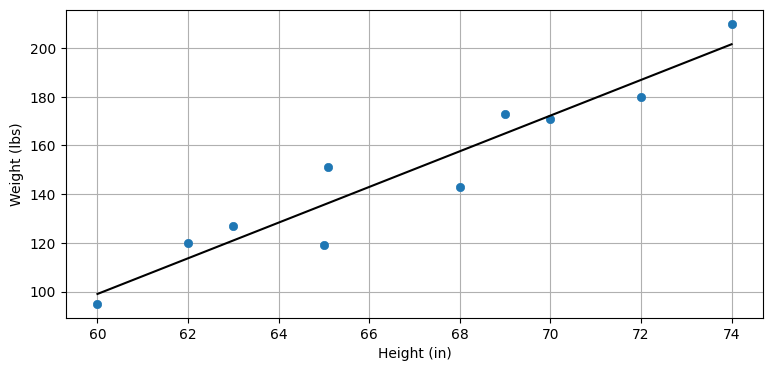

In [64]:
from kf_book.gaussian_internal import plot_correlated_data

height = [60, 62, 63, 65, 65.1, 68, 69, 70, 72, 74]
weight = [95, 120, 127, 119, 151, 143, 173, 171, 180, 210]
plot_correlated_data(height, weight, 'Height (in)', 'Weight (lbs)', False)

In this book we only consider *linear correlation*. We assume that the relationship between variables is linear. That is, a straight line is a good fit for the data. I've fit a straight line through the data in the above chart. The concept of *nonlinear correlation* exists, but we will not be using it.

The equation for the covariance between $X$ and $Y$ is

$$ COV(X, Y) = \sigma_{xy} = \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]$$

Where $\mathbb E[X]$ is the *expected value* of X, defined as

$$ \mathbb E[X] =  \begin{cases} \sum_{i=1} ^n p_ix_i & \makebox{discrete}\\ \int_{-\infty}^\infty f(x)\, x dx & \makebox{continuous} \end{cases} $$ 
 
We assume each data point is equally likely, so the probability of each is $\frac{1}{N}$, giving

$$\mathbb E[X] =  \frac{1}{N}\sum_{i=1}^n x_i$$

for the discrete case we will be considering.

Compare the covariance equation to the equation for the variance. As you can see they are very similar:

$$\begin{aligned}VAR(X) = \sigma_x^2 &= \mathbb E[(X - \mu)^2]\\
COV(X, Y) = \sigma_{xy} &= \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]\end{aligned}$$

In particular, if you compute $COV(X, X)$ you get the equation for $VAR(X)$, which supports my statement that the variance computes how a random variable varies amongst itself.

We use a *covariance matrix* to denote covariances of a multivariate normal distribution, and it looks like this:
$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

The diagonal contains the variance for each variable, and the off-diagonal elements contain the covariance between the $i^{th}$ and $j^{th}$ variables. So $\sigma_3^2$ is the variance of the third variable, and $\sigma_{13}$ is the covariance between the first and third variables.

A covariance of 0 indicates no correlation. If the variance for $x$ is 10, the variance for $y$ is 4, and there is no linear correlation between $x$ and $y$, then we would write

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

If there was a small amount of positive correlation between $x$ and $y$ we might have

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

where 1.2 is the covariance between $x$ and $y$. I say the correlation is "small" because the covariance of 1.2 is small relative to the variances of 10. 

If there was a large amount of negative correlation between  between $x$ and $y$ we might have
$$\Sigma = \begin{bmatrix}10&-9.7\\-9.7&4\end{bmatrix}$$

The covariance matrix is symmetric. After all, the covariance between $x$ and $y$ is always equal to the covariance between $y$ and $x$. That is, $\sigma_{xy}=\sigma_{yx}$ for any $x$ and $y$.

I fear I might be losing you, so let's work an example. In the **Gaussians** chapter we had a class of students with heights H=[1.8, 2.0, 1.7, 1.9, 1.6] meters. We computed:

$$\begin{aligned}
\mathit{VAR}(H) &= E[(H - \mu_H)^2] \\
&= \frac{1}{N}\sum_{i=1}^n (H_i - \mu_H)^2 \\
&= \frac{1}{5}\left[(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2\right] \\
&= 0.02
\end{aligned}$$

Easy, right? If we weigh the students we might find their weights to be W = [70.1, 91.2, 59.5, 93.2, 53.5]. Can we use the covariance equation to create the covariance matrix? Sure. It will look like:

$$\Sigma = \begin{bmatrix}\sigma_H^2 & \sigma_{H,W} \\
\sigma_{W,H} & \sigma_{W}^2\end{bmatrix}$$

We just computed the variance of the height, and it will go in the upper left hand corner of the matrix. The lower right corner contains the variance in weights. Using the same equation we get:

$$\begin{aligned}
\mu_W &= \frac{1}{5}(70.1 + 91.2 + 59.5 + 93.2 + 53.5) = 73.5 \\
\sigma_W^2 &= \frac{1}{5}\left[(70.1-73.5)^2 + (91.2-73.5)^2 + (59.5-73.5)^2 + (93.2-73.5)^2 + (53.5-73.5)^2\right] \\
&= 261.8
\end{aligned}$$

Now the covariances. Using the formula above, we compute:

$$\begin{aligned}
\sigma_{H,W} &= \mathbb E\big[(H-\mu_H)(W-\mu_W)\big] \\
&= \frac{1}{N}\sum_{i=1}^n (H_i-\mu_H)(W_i-\mu_W) \\
&= \frac{1}{5}[(1.8-1.8)(70.1-73.5) + (2-1.8)(91.2-73.5) + (1.7-1.8)(59.5-73.5)\, +\\
&\, \, \, \,  \, (1.9-1.8)(93.2-73.5) + (1.6-1.8)(53.5-73.5)] \\
&= 2.18
\end{aligned}$$

That was tedious, but easy enough. We will never do that again because, of course, NumPy will compute it for you. 

In [65]:
import numpy as np

W = [70.1, 91.2, 59.5, 93.2, 53.5]
H = [1.8, 2.0, 1.7, 1.9, 1.6]
np.cov(H, W)

array([[  0.025,   2.727],
       [  2.727, 327.235]])

That doesn't agree with our calculation! What went wrong? Nothing. NumPy applies a correction for small sample sizes; it uses $\frac{1}{N-1}$ as the normalization term instead of $\frac{1}{N}$.

This is a bit beyond the scope of this book. Briefly, suppose the actual class size is 200 students, and we took a sample of 5 students to perform this computation because we couldn't afford to measure and weigh all 200 students. It is nearly certain that there will be some error in our estimator because the sample is unlikely to perfectly represent the class. As our sample size approaches 200 the error will approach 0. We say there is no *bias* in the latter, and that we have an *unbiased estimator*. In contrast, when we take a small sample there is bias (error is nonzero), and we have a *biased estimator*.

If the error is zero it makes sense to divide by $N$. I will not prove why, but for biased estimators we use $\frac{1}{N-1}$ to correct for the small sample size. NumPy does this by default because in practice we are almost always working from data samples from a larger collection. If you want the unbiased estimator, which we computed above, use `bias=1` in the call to `np.cov'.

In [66]:
np.cov(H, W, bias=1)

array([[  0.02 ,   2.182],
       [  2.182, 261.788]])

This agrees with our computation. We will not use `bias=1` again in this book since we are using *random variables* which are sampling from the infinite set of positions of the objects we are tracking. Here we are computing the variance and covariance for the entire population, so `bias=1` is correct.

What does this matrix tell us? It tells us the variance in heights is 0.02 $m^2$ and the variance in weights is 261.788 $kg^2$. Furthermore, it tells us the weights and heights are positively correlated - as heights increase so do the weights.

Let's create perfectly correlated data. By this I mean that the data perfectly fits on a line - there is no variance from the line.

In [67]:
X = np.linspace(1, 10, 100)
Y = np.linspace(1, 10, 100)
np.cov(X, Y)

array([[6.956, 6.956],
       [6.956, 6.956]])

We can see from the covariance matrix that the covariance is equal to the variance in x and in y. 

Now let's add some noise to one of the variables so that they are no longer perfectly correlated. I will make $Y$ negative to create a negative correlation.

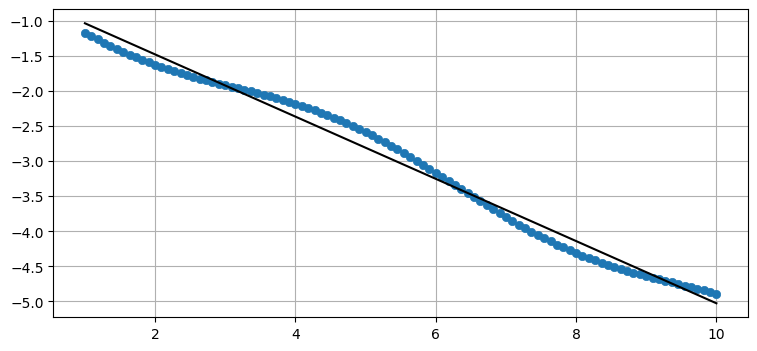

[[ 6.956 -3.084]
 [-3.084  1.387]]


In [68]:
X = np.linspace(1, 10, 100)
Y = -(np.linspace(1, 5, 100) + np.sin(X)*.2)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

The data no longer forms a straight line. The covariance is $\sigma_{xy}=-3.08$. It is not close to zero compared to the magnitudes of $\sigma_x^2$ and $\sigma_y^2$, and so we know there is still a high degree of correlation. We can verify this by looking at the chart. The data forms nearly a straight line.

Now I will add random noise to a straight line.

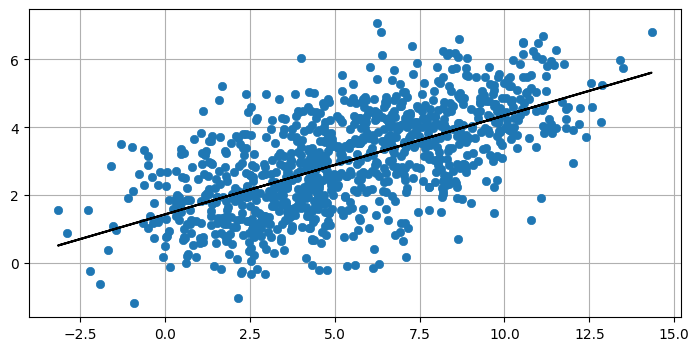

[[9.959 2.9  ]
 [2.9   2.214]]


In [69]:
from numpy.random import randn
X = np.linspace(1, 10, 1000) + randn(1000)*2
Y = np.linspace(1, 5, 1000) + randn(1000)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

We see that the covariance is smaller in relation to the variances, reflecting the lower correlation between $X$ and $Y$. We can still fit a straight line through this data, but there is much greater variation in the data.

Finally, here is the covariance between completely random data.

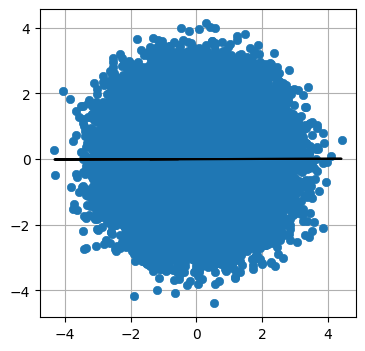

[[0.996 0.003]
 [0.003 1.004]]


In [70]:
X = randn(100000)
Y = randn(100000)
plot_correlated_data(X, Y)
print(np.cov(X, Y))

Here the covariances are very near zero. As you can see with the plot, there is no clear way to draw a line to fit the data. A vertical line would be as unconvincing as the horizontal line I've shown.

## Multivariate Normal Distribution Equation

Recall the equation for the normal distribution from the **Gaussians** chapter:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \Big [{-\frac{1}{2}}{(x-\mu)^2}/\sigma^2 \Big ]
$$


Here is the multivariate normal distribution in $n$ dimensions.

$$
f(\mathbf{x},\, \mu,\,\Sigma) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}}\, \exp  \Big [{ -\frac{1}{2}(\mathbf{x}-\mu)^\mathsf{T}\Sigma^{-1}(\mathbf{x}-\mu) \Big ]}
$$

The multivariate version merely replaces the scalars of the univariate equations with matrices. If you are reasonably well-versed in linear algebra this equation should look quite manageable. If not, don't worry, both FilterPy and SciPy provide functions to compute it for you. Let's ignore the computation for a moment and plot it to see what it looks like.

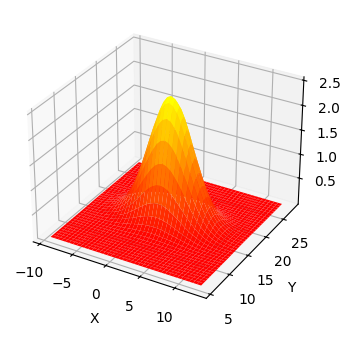

In [71]:
import kf_book.mkf_internal as mkf_internal

mean = [2., 17.]
cov = [[10., 0.], 
       [0., 4.]]

mkf_internal.plot_3d_covariance(mean, cov)

This is a plot of multivariate Gaussian with a mean of $\mu=[\begin{smallmatrix}2\\17\end{smallmatrix}]$ and a covariance of $\Sigma=[\begin{smallmatrix}10&0\\0&4\end{smallmatrix}]$. The three dimensional shape shows the probability density for any value of $(X, Y)$ in the z-axis. I have projected the variance for x and y onto the walls of the chart - you can see that they take on the Gaussian bell curve shape. The curve for $X$ is wider than the curve for $Y$, which is explained by $\sigma_x^2=10$ and $\sigma_y^2=4$. The highest point of the 3D surface is at the the means for $X$ and $Y$. 

All multivariate Gaussians have this shape. If we think of this as the Gaussian for the position of a dog, the z-value at each point of ($X, Y$) is the probability density of the dog being at that position. Strictly speaking this is the *joint probability density function*, which I will define soon. So, the dog has the highest probability of being near (2, 17), a modest probability of being near (5, 14), and a very low probability of being near (10, 10). As with the univariate case this is a *probability density*, not a *probability*. Continuous distributions have an infinite range, and so the probability of being exactly at (2, 17), or any other point, is 0%. We can compute the probability of being within a given range by computing the volume under the surface with an integral.

FilterPy [2] implements the equation with the function `multivariate_gaussian()` in the `filterpy.stats.` module. SciPy's `stats` module implements the multivariate normal equation with `multivariate_normal()`. It implements a 'frozen' form where you set the mean and covariance once, and then calculate the probability density for any number of values for x over any arbitrary number of calls. I named my function `multivariate_gaussian()` to ensure it is never confused with the SciPy version.

> The <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">tutorial</a>[1] for the `scipy.stats` module explains 'freezing' distributions and other very useful features.

In [72]:
from filterpy.stats import gaussian, multivariate_gaussian

I'll demonstrate using it, and then move on to more interesting things.

First, let's find the probability density for our dog being at (2.5, 7.3) if we believe he is at (2, 7) with a variance of 8 for $x$ and a variance of 3 for $y$.

Start by setting $x$ to (2.5, 7.3). You can use a tuple, list, or NumPy array.

In [73]:
x = [2.5, 7.3]

Next, we set the mean of our belief:

In [74]:
mu = [2.0, 7.0]

Finally, we have to define our covariance matrix. In the problem statement we did not mention any correlation between $x$ and $y$, and we will assume there is none. This makes sense; a dog can choose to independently wander in either the $x$ direction or $y$ direction without affecting the other. I will use the variable name `P`. Kalman filters use the name $\textbf{P}$ for the covariance matrix, and we need to become familiar with the conventions.

In [75]:
P = [[8., 0.], 
     [0., 3.]]

Now call the function

In [76]:
%precision 4
multivariate_gaussian(x, mu, P)

0.0315

We can get the same result from the `scipy.stats` module.

In [77]:
import scipy
from scipy.stats import multivariate_normal
print(f'{multivariate_normal(mu, P).pdf(x):.4f}')


0.0315


It's time to define some terms. The *joint probability*, denoted $P(x,y)$, is the probability of both $x$ and $y$ happening.  For example, if you roll two die $P(2,5)$ is the probability of the first die rolling a 2 and the second die rolling a 5. Assuming the die are six sided and fair, the probability $P(2,5) = \frac{1}{6}\times \frac{1}{6}=\frac{1}{36}$. The 3D chart above shows the *joint probability density function*.

The *marginal probability* is the probability of an event happening without regard of any other event. In the chart above the Gaussian curve drawn to the left is the marginal for $Y$. This is the probability for the dog being at any position in $Y$ disregarding the value for $X$. Earlier I wrote "I have projected the variance for x and y onto the walls of the chart"; these are the marginal probabilities for $x$ and $y$. Another computational benefit of Gaussians is that the marginal of a multivariate Gaussian is another Gaussian!

Let's look at this in a slightly different way. Instead of plotting a surface showing the probability distribution I will generate 1,000 points with the distribution of $[\begin{smallmatrix}8&0\\0&3\end{smallmatrix}]$.

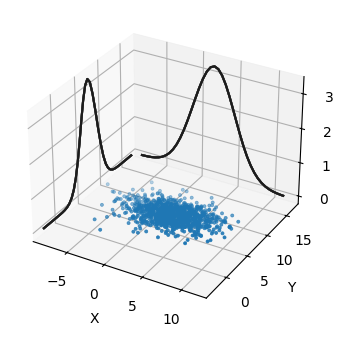

In [78]:
mkf_internal.plot_3d_sampled_covariance(mu, P)

We can think of the sampled points as being possible locations for our dog given those particular mean and covariances. The contours on the side show the marginal probability for $X$ and $Y$. We can see that he is far more likely to be at (2, 7) where there are many points, than at (-5, 5) where there are few.

As beautiful as these plots are, it is hard to get useful information from them. For example, it is not easy to tell if $X$ and $Y$ both have the same variance, and how much they are correlated. In most of the book I'll display Gaussians as contour plots.

The contour plots display the range of values that the multivariate Gaussian takes for a specific standard deviation. This is like taking a horizontal slice out of the 3D plot.

These plots show the shape of the slice for 3 standard deviations.

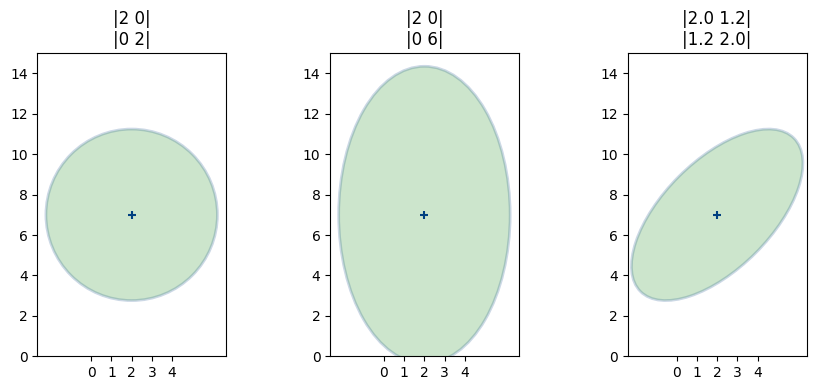

In [79]:
mkf_internal.plot_3_covariances()

For those of you viewing this online or in Juptyer Notebook on your computer, here is an animation of varying the covariance while holding the variance constant.

<img src='animations/multivariate_ellipse.gif'>

(source: http://git.io/vqxLS)

These plots look like circles and ellipses. Indeed, it turns out that any slice through the multivariate Gaussian is an ellipse. Hence, in statistics we do not call these 'contour plots', but either *error ellipses* or *confidence ellipses*; the terms are interchangable.

This code uses the function `plot_covariance_ellipse()` from `filterpy.stats`. By default the function displays one standard deviation, but you can use either the `variance` or `std` parameter to control what is displayed. For example, `variance=3**2` or `std=3` would display the 3rd standard deviation, and `variance=[1,4,9]` or `std=[1,2,3]` would display the 1st, 2nd, and 3rd standard deviations. 

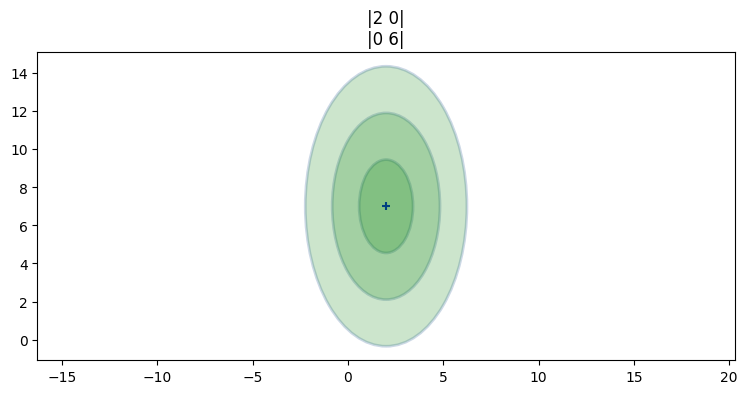

In [80]:
from filterpy.stats import plot_covariance_ellipse
import matplotlib.pyplot as plt

P = [[2, 0], [0, 6]]
plot_covariance_ellipse(np.asarray((2, 7)), P, fc='g', alpha=0.2, 
                        std=np.asarray([1,2,3]),
                        title='|2 0|\n|0 6|')
plt.gca().grid(False);

The solid colors may suggest to you that the probability distribution is constant between the standard deviations. This is not true, as you can tell from the 3D plot of the Gaussian. Here is a 2D shaded representation of the probability distribution for the covariance ($\begin{smallmatrix}2&1.2\\1.2&1.3\end{smallmatrix})$. Darker gray corresponds to higher probability density.

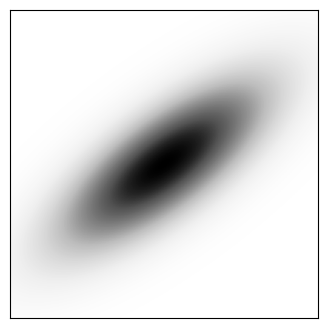

In [81]:
from kf_book.nonlinear_plots import plot_cov_ellipse_colormap
plot_cov_ellipse_colormap(cov=[[2, 1.2], [1.2, 1.3]]);

Thinking about the physical interpretation of these plots clarifies their meaning. The mean and covariance of the first plot is

$$
\mathbf{\mu} =\begin{bmatrix}2\\7\end{bmatrix},\, \,
\Sigma = \begin{bmatrix}2&0\\0&2 \end{bmatrix}
$$ 

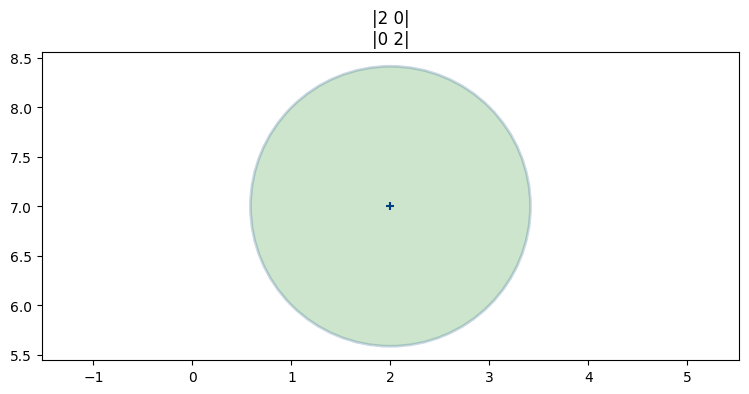

In [82]:
x = [2, 7]
P = [[2, 0], [0, 2]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                       title='|2 0|\n|0 2|')
plt.gca().grid(False)

A Bayesian way of thinking about this is that the ellipse shows us the amount of error in our belief. A tiny circle would indicate that we have a very small error, and a very large circle indicates a lot of error in our belief. The shape of the ellipse shows us the geometric relationship of the errors in $X$ and $Y$. Here we have a circle so errors in $X$ and $Y$ are equally likely.

The mean and covariance of the second plot are

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&0\\0&6\end{bmatrix}
$$

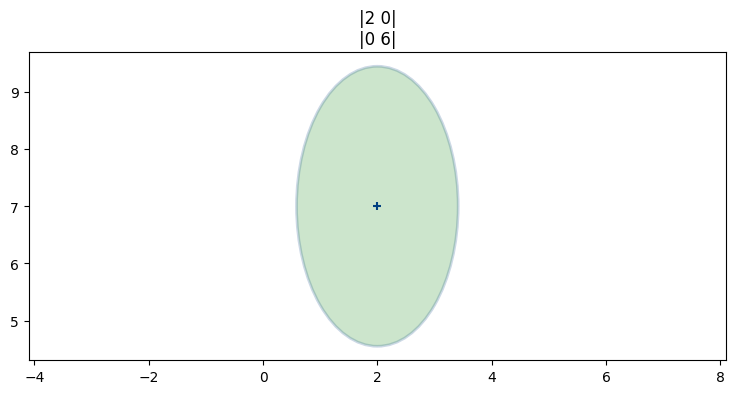

In [83]:
x = [2, 7]
P = [[2, 0], [0, 6]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                    title='|2 0|\n|0 6|')
plt.gca().grid(False)

This time we use a different variance for $X$ ($\sigma_x^2=2$) vs $Y$ ($\sigma^2_y=6$). The result is a tall and narrow ellipse. We can see that a lot more uncertainty in $Y$ vs $X$. In both cases we believe the dog is at (2, 7), but the uncertainties are different.

The third plot shows the mean and covariance

$$
\mu =\begin{bmatrix}2\\7\end{bmatrix}, \, \, \, 
\Sigma = \begin{bmatrix}2&1.2\\1.2&2\end{bmatrix}
$$

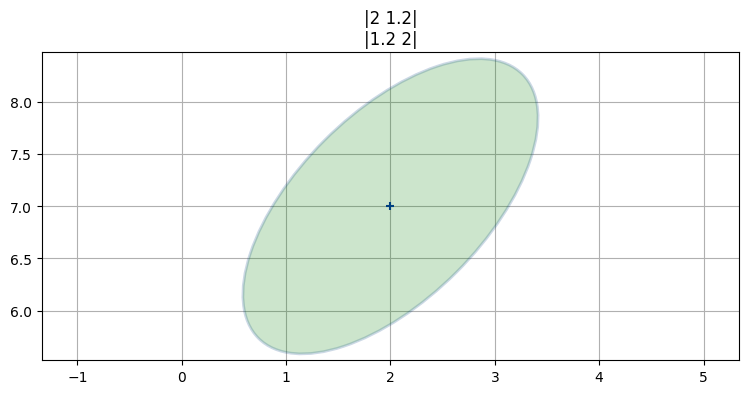

In [84]:
x = [2, 7]
P = [[2, 1.2], [1.2, 2]]
plot_covariance_ellipse(x, P, fc='g', alpha=0.2, 
                    title='|2 1.2|\n|1.2 2|')

This is the first contour that has values in the off-diagonal elements of the covariance, and this is the first contour plot with a slanted ellipse. This is not a coincidence. The two facts are telling us the same thing. A slanted ellipse tells us that the $x$ and $y$ values are somehow correlated. The off-diagonal elements in the covariance matrix are non-zero, indicating that a correlation exists.

Recall the plot for height versus weight. It formed a slanted grouping of points. We can use NumPy's `cov()` function to compute the covariance of two or more variables by placing them into a 2D array. Let's do that, then plot the $2\sigma$ covariance ellipse on top of the data. We will need to use `bias=1` because the data represents the entire population; it is not a sample.

In [85]:
cov_hw = np.cov(np.vstack((height, weight)), bias=1)
cov_hw

array([[  18.525,  135.701],
       [ 135.701, 1092.29 ]])

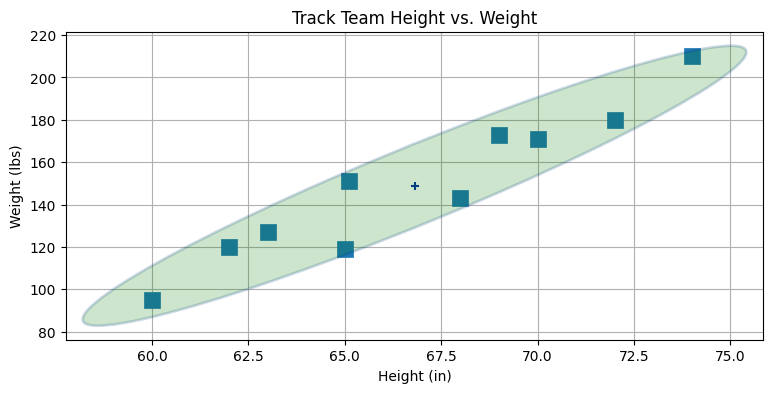

In [86]:
plt.scatter(height, weight, s=120, marker='s')
plt.title('Track Team Height vs. Weight')
plt.xlabel('Height (in)'); plt.ylabel('Weight (lbs)')
plot_covariance_ellipse((np.mean(height), np.mean(weight)), cov_hw, fc='g', 
                        alpha=0.2, axis_equal=False, std=2)

This should help you form a strong intuition on the meaning and use of covariances. The covariance ellipse shows you how the data is 'scattered' in relation to each other. A narrow ellipse like this tells you that the data is very correlated. There is only a narrow range of weights for any given height. The ellipse leans towards the right, telling us there is a positive correlation - as x increases y also increases. If the ellipse leaned towards the left then the correlation would be negative - as x increases y decreases. We can see this in the following plot:

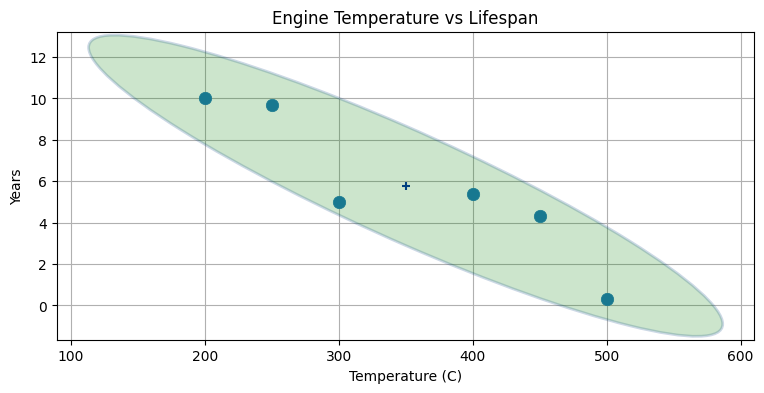

In [87]:
max_temp = [200, 250, 300, 400, 450, 500]
lifespan = [10, 9.7, 5, 5.4, 4.3, 0.3]

plt.scatter(max_temp, lifespan, s=80)
cov = np.cov(np.vstack((max_temp, lifespan)))
plot_covariance_ellipse((np.mean(max_temp), np.mean(lifespan)), cov, fc='g', 
            alpha=0.2, axis_equal=False, std=2)
plt.title('Engine Temperature vs Lifespan')
plt.xlabel('Temperature (C)'); plt.ylabel('Years');

The relationships between variances and covariances can be hard to puzzle out by inspection, so here is an interactive plot. (If you are reading this in a static form instructions to run this online are here: https://git.io/vza7b)

In [88]:
import matplotlib as plt

In [89]:
import matplotlib.pyplot as plt
from ipywidgets import interact
from kf_book.book_plots import figsize, FloatSlider

fig = None
def plot_covariance(var_x, var_y, cov_xy):
    global fig
    if fig: plt.close(fig)
    fig = plt.figure(figsize=(4,4))
    P1 = [[var_x, cov_xy], [cov_xy, var_y]]

    plot_covariance_ellipse((10, 10), P1, axis_equal=False,
                            show_semiaxis=True)

    plt.xlim(4, 16)
    plt.gca().set_aspect('equal')
    plt.ylim(4, 16)

    
with figsize(y=6):
    interact (plot_covariance,           
          var_x=FloatSlider(5, min=0, max=20), 
          var_y=FloatSlider(5, min=0, max=20), 
          cov_xy=FloatSlider(1.5, min=0, max=50, step=.2));

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='var_x', max=20.0), FloatSli…

### Pearson's Correlation Coefficient

We will not be using this coefficient in this book, but you may see it elsewhere. You can safely skip this section if uninterested.

The correlation between two variables can be given a numerical value with *Pearson's Correlation Coefficient*. It is defined as

$$\rho_{xy} = \frac{COV(X, Y)}{\sigma_x \sigma_y}$$

This value can range in value from -1 to 1. If the covariance is 0 than $\rho=0$. A value greater than 0 indicates that the relationship is a positive correlation, and a negative value indicates that there is a negative correlation. Values near -1 or 1 indicate a very strong correlation, and values near 0 indicate a very weak correlation.

Correlation and covariance are very closely related. Covariance has units associated with it, and correlation is a unitless ratio. For example, for our dog $\sigma_{xy}$ has units of meters squared.

We can use `scipy.stats.pearsonr` function to compute the Pearson coefficient. It returns a tuple of the Pearson coefficient and of the 2 tailed p-value. The latter is not used in this book. Here we compute $\rho$ for height vs weight of student athletes:

In [90]:
from scipy.stats import pearsonr
pearsonr(height, weight)[0]

0.9540

Here we compute the correlation between engine temperature and lifespan.

In [91]:
pearsonr(max_temp, lifespan)[0]

-0.9178

## Using Correlations to Improve Estimates

Suppose we believe our dog is at position (5, 10) with some given covariance. If the standard deviation in x and y is each 2 meters, but they are strongly correlated, the covariance contour would look something like this.

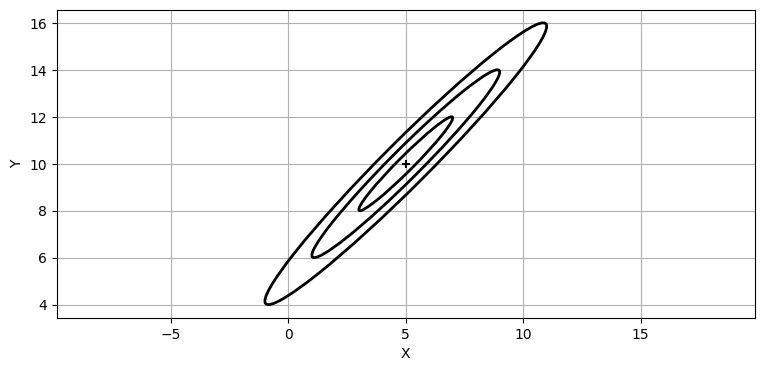

In [92]:
P = [[4, 3.9], [3.9, 4]]

plot_covariance_ellipse((5, 10), P, ec='k', std=[1, 2, 3])
plt.xlabel('X')
plt.ylabel('Y');

Now suppose I were to tell you that we know that $x=7.5$. What can we infer about the value for $y$? The position is extremely likely to lie within the 3$\sigma$ covariance ellipse. We can infer the position in *y* based on the covariance matrix because there is a correlation between *x* and *y*. I've illustrated the likely range of values for y as a blue filled circle.

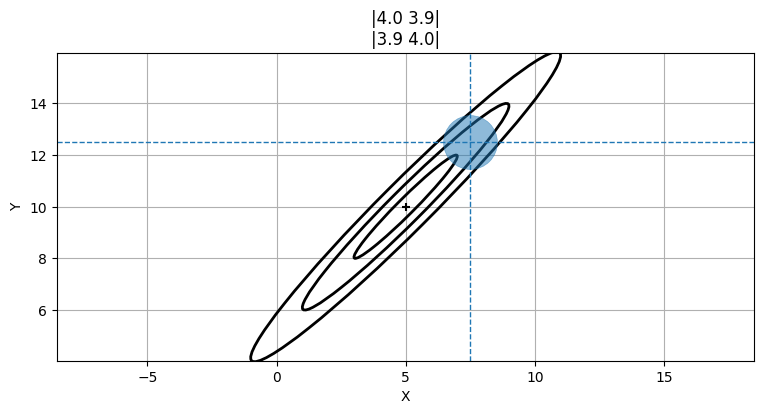

In [93]:
mkf_internal.plot_correlation_covariance()

The circle not mathematically correct, but it gets the idea across. We will tackle the mathematics in the next section. For now recognize that we can predict that $y$ is likely near 12. A value of $y=-10$ is extremely improbable.

A word about *correlation* and *independence*. If variables are *independent* they can vary separately. If you walk in an open field, you can move in the $x$ direction (east-west), the $y$ direction(north-south), or any combination thereof. Independent variables are always also *uncorrelated*. Except in special cases, the reverse does not hold true. Variables can be uncorrelated, but dependent. For example, consider $y=x^2$. Correlation is a linear measurement, so $x$ and $y$ are uncorrelated. However, $y$ is dependent on $x$. 

## Multiplying Multidimensional Gaussians

In the previous chapter we incorporated an uncertain measurement with an uncertain estimate by multiplying their Gaussians together. The result was another Gaussian with a smaller variance. If two pieces of uncertain information corroborate each other we should be more certain in our conclusion. The graphs look like this:

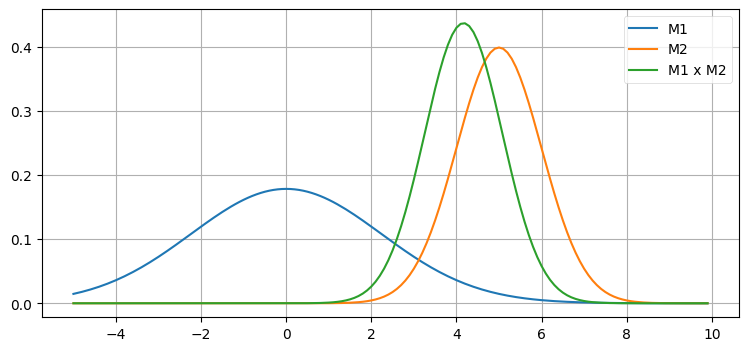

In [94]:
mkf_internal.plot_gaussian_multiply()

The combination of measurements 1 and 2 yields more certainty, so the new Gaussian is taller and narrower - the variance became smaller. The same happens in multiple dimensions with multivariate Gaussians.

Here are the equations for multiplying multivariate Gaussians. The capital sigma ($\Sigma$) indicates that these are matrices, not scalars. Specifically, they are covariance matrices:

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$


They are generated by plugging the multivariate Gaussians for the prior and the estimate into Bayes Theorem. I gave you the algebra for the univariate case in the  **Gaussians** chapter. 

You will not need to remember these equations as they are computed by Kalman filter equations that will be presented shortly. This computation is also available in FilterPy using the `multivariate_multiply()` method, which you can import from `filterpy.stats`. 

To give you some intuition about this, recall the equations for multiplying univariate Gaussians:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

This looks similar to the equations for the multivariate equations. This will be more obvious if you recognize that matrix inversion, denoted by the -1 power, is *like* a reciprocal since $AA^{-1} =I$. I will rewrite the inversions as divisions - this is not a mathematically correct thing to do as division for matrices is not defined, but it does help us compare the equations.

$$\begin{aligned}
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

In this form the relationship between the univariate and multivariate equations is clear.

Now let's explore multivariate Gaussians in terms of a concrete example. Suppose that we are tracking an aircraft with two radar systems. I will ignore altitude so I can use two dimensional plots. Radar provides the range and bearing to a target. We start out being uncertain about the position of the aircraft, so the covariance, which is our uncertainty about the position, might look like this. In the language of Bayesian statistics this is our *prior*. 

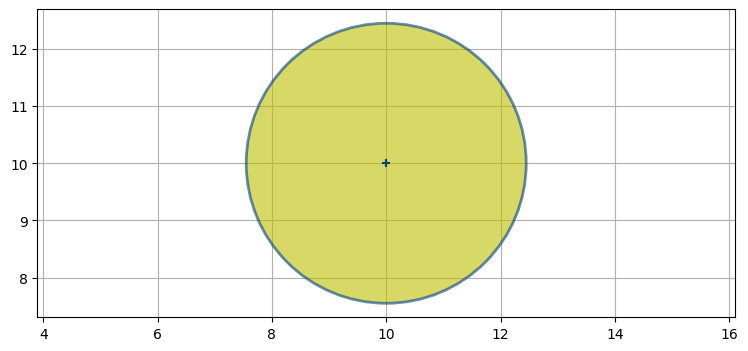

In [95]:
P0 = [[6, 0], [0, 6]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)

Now suppose that there is a radar to the lower left of the aircraft. Further suppose that the radar's bearing measurement is accurate, but the range measurement is inaccurate. The covariance for the error in the measurement might look like this (plotted in green on top of the yellow prior):

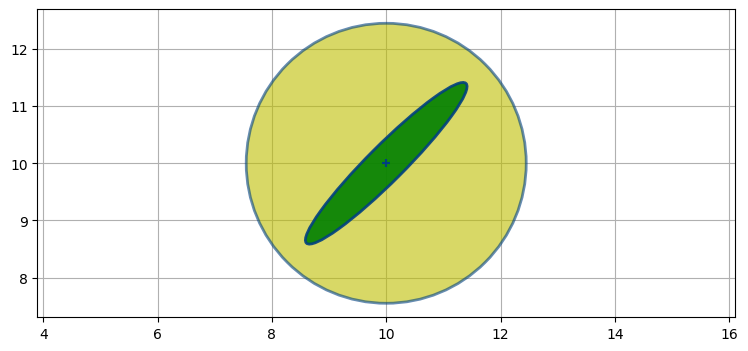

In [96]:
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, fc='g', alpha=0.9)

Recall that Bayesian statistics calls this the *evidence*. The ellipse points towards the radar. It is very long because the range measurement is inaccurate, and the aircraft could be within a considerable distance of the measured range. It is very narrow because the bearing estimate is very accurate and thus the aircraft must be very close to the bearing estimate.

We want to find the *posterior* - the mean and covariance that results from incorporating the evidence into the prior. As in every other chapter we combine evidence by multiplying them together. 

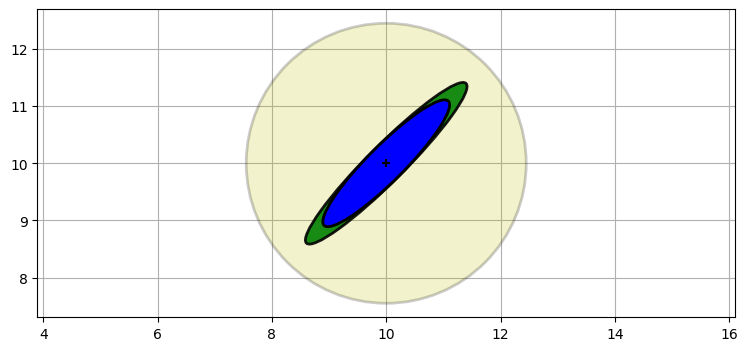

In [97]:
from filterpy.stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.9)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

I have plotted the original estimate (prior) in a very transparent yellow, the radar reading in green (evidence), and the finale estimate (posterior) in blue.

The posterior retained the same shape and position as the radar measurement, but is smaller. We've seen this with one dimensional Gaussians. Multiplying two Gaussians makes the variance smaller because we are incorporating more information, hence we are less uncertain.  Another point to recognize is that the covariance shape reflects the physical layout of the aircraft and the radar system. The importance of this will become clear in the next step.

Now let's say we get a measurement from a second radar, this one to the lower right. The posterior from the last step becomes our new prior, which I plot in yellow. The new measurement is plotted in green.

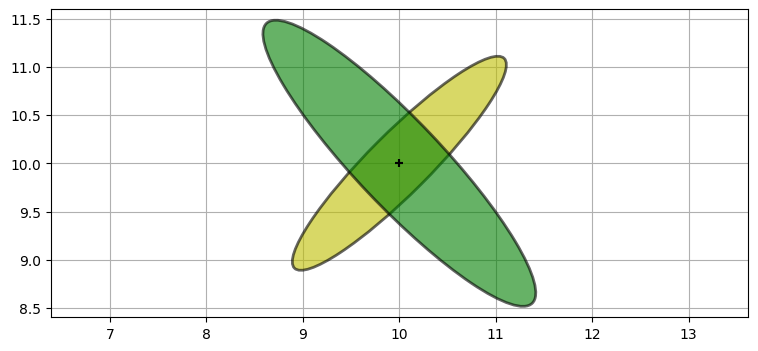

In [98]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)

We incorporate this  information by multiplying the Gaussians:

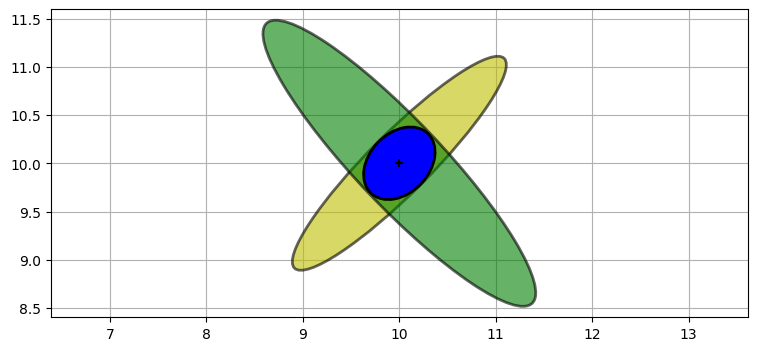

In [99]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

The only likely place for the aircraft is where the two ellipses intersect. The intersection, formed by multiplying the prior and measurement, is a new Gaussian. The shapes reflects the geometry of the problem. This allows us to *triangulate* on the aircraft, resulting in a very accurate estimate. We didn't explicitly write any code to perform triangulation; it was a natural outcome of multiplying the Gaussians of each measurement together.

Think back to the **g-h Filter** chapter where we displayed the error bars of two weighings on a scale. The estimate must fall somewhere within the region where the error bars overlap. Here the estimate must fall between 161 to 163 pounds.

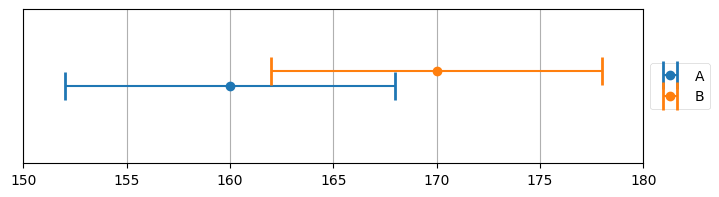

In [100]:
import kf_book.book_plots as book_plots
book_plots.plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

Let's consider a different layout. Suppose the first radar is directly to the left of the aircraft. I can model the measurement error with
$$\Sigma = \begin{bmatrix}2&0\\0&0.2\end{bmatrix}$$

Here we see the result of multiplying the prior with the measurement.

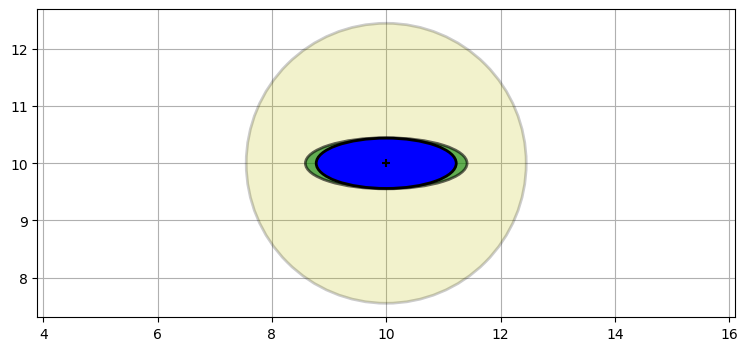

In [101]:
P1 = [[2, 0], [0, .2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

Now we can incorporate the measurement from the second radar system, which we will leave in the same position as before.

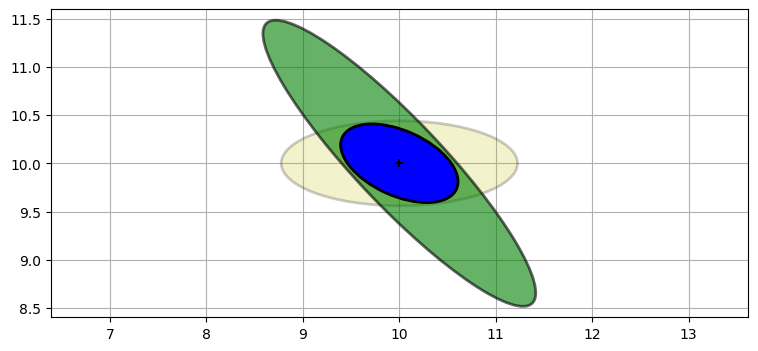

In [102]:
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

Our estimate is not as accurate as the previous example.  **The two radar stations are no longer orthogonal to each other relative to the aircraft's position so the triangulation is not optimal**.

For a final example, imagine taking two measurements from the same radar **a short time apart**. The covariance ellipses will nearly overlap, leaving a very large error in our new estimate:

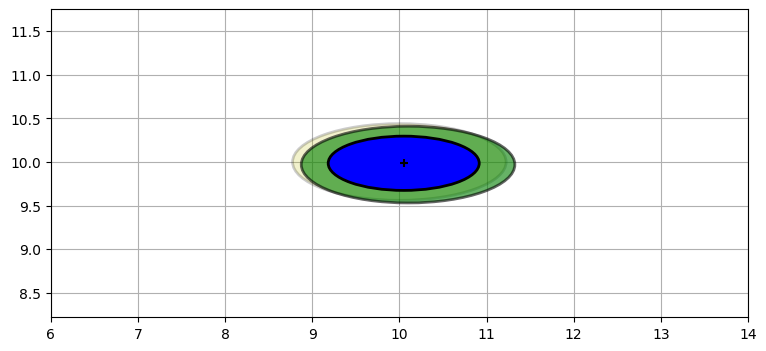

In [103]:
P5 = multivariate_multiply((10,10), P2, (10.1, 9.97), P2)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10.1, 9.97), P2, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse(P5[0], P5[1], ec='k', fc='b')
plt.xlim(6, 14);

## Hidden Variables

You can already see why a multivariate Kalman filter can perform better than a univariate one. Correlations between variables can significantly improve our estimates. We can take this much further. **This section contains the key insight to this chapter, so read carefully**.

Let's say we are tracking an aircraft and we get the following data for the $x$ and $y$ coordinates at time $t$=1, 2, and 3 seconds. What does your intuition tell you the value of $x$ will be at time $t$=4 seconds?

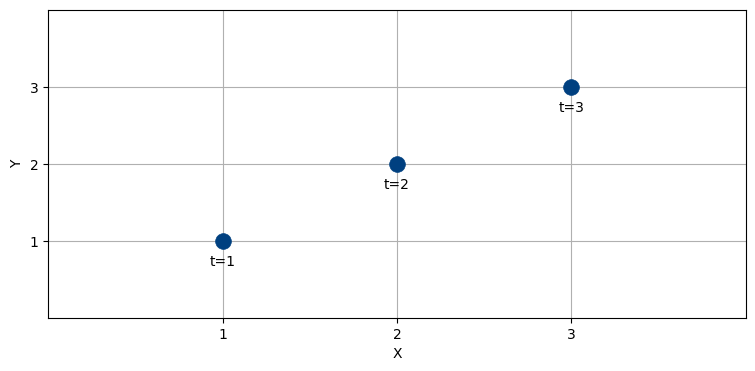

In [104]:
mkf_internal.show_position_chart()

It appears that the aircraft is flying in a straight line and we know that aircraft cannot turn on a dime. The most reasonable guess is that at $t$=4 the aircraft is at (4,4). I will depict that with a green arrow.

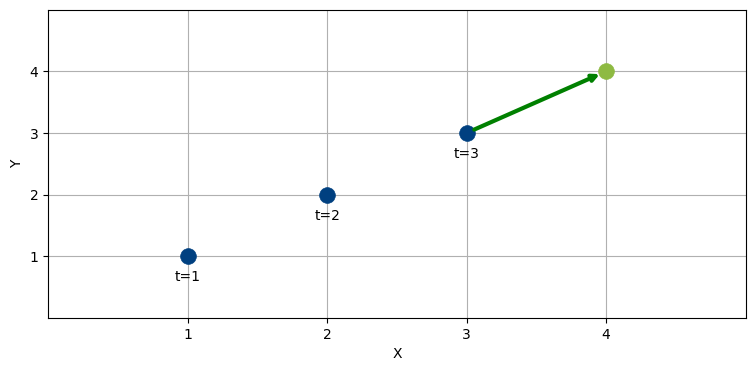

In [105]:
mkf_internal.show_position_prediction_chart()

You made this inference because you *inferred* a constant velocity for the airplane. The reasonable
assumption is that the aircraft is moving one unit each in *x* and *y* per time step.

Think back to the **g-h Filter** chapter when we were trying to improve the weight predictions of a noisy scale. We incorporated *weight gain* into the equations because it allowed us to make a better prediction of the weight the next day. The g-h filter uses the $g$ parameter to scale the amount of significance given to the current weight measurement, and the $h$ parameter scaled the amount of significance given to the weight gain.

We are going to do the same thing with our Kalman filter. After all, the Kalman filter is a form of a g-h filter. In this case we are tracking an airplane, so instead of weight and weight gain we need to track position and velocity. Weight gain is the *derivative* of weight, and of course velocity is the derivative of position. It's impossible to plot and understand the 4D chart that would be needed to plot *x* and *y* and their respective velocities so let's do it for $x$, knowing that the math generalizes to more dimensions.

At time 1 we might be fairly certain about the position (x=0) but have no idea about the velocity. We can plot that with a covariance matrix like this. The narrower width expresses our relative certainty about position, and the tall height expresses our lack of knowledge about velocity.

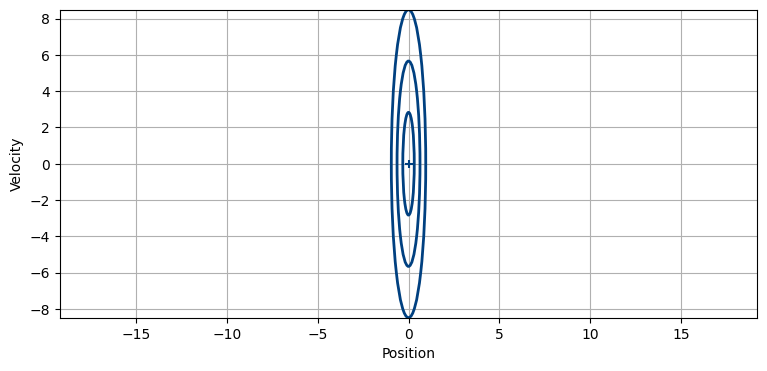

In [106]:
mkf_internal.show_x_error_chart(1)

However, position and velocity are correlated. If the velocity is 5 m/s, then in 1 second the position will be 5 m. If the velocity is -10 m/s then in 1 second the position will be -10 m. Let's visualize this with a velocity covariance drawn on the diagonal. 

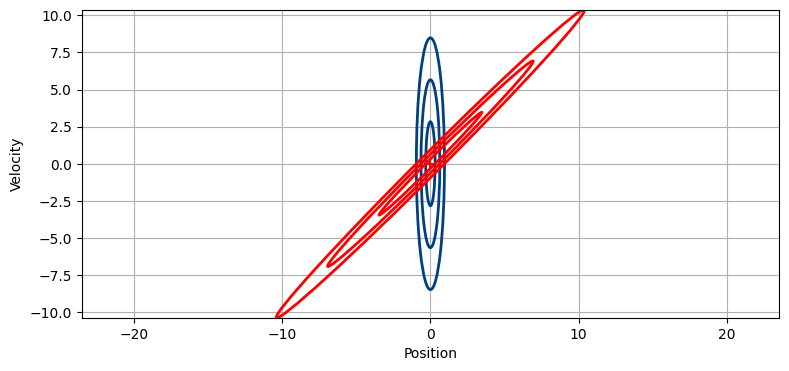

In [107]:
mkf_internal.show_x_error_chart(2)

At this point the velocity covariance doesn't help us. We can't predict a new position because we have no idea what the velocity is. But after one second we get a position update of x=5.

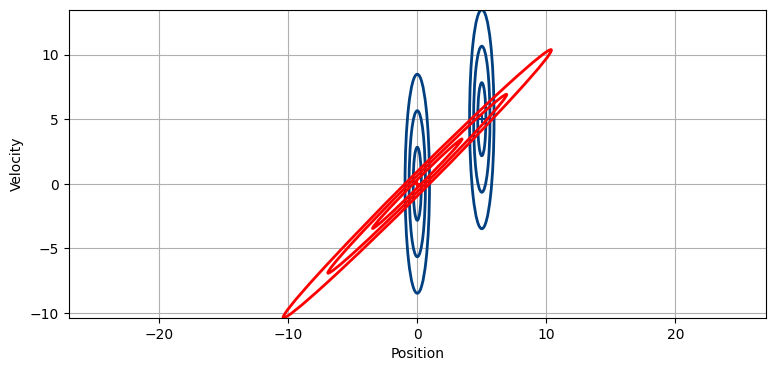

In [108]:
mkf_internal.show_x_error_chart(3)

It won't be clear until the next chapter how I calculate what I'm about to say. Ignore the calculation, and think about what this implies. We have no easy way to say where the object really is because we are so uncertain about the velocity. Hence the ellipse stretches very far in the x-axis. Our uncertainty in velocity of course means it is also very spread in the y-axis. But as I said in the last paragraph, position is correlated to velocity. If the velocity is 5 m/s the next position would be 5, and if the velocity is 10 the next position would be 10. They are very correlated, so the ellipse must be very narrow. 

This superposition of the two covariances is where the magic happens. The only reasonable estimate at time t=1 (where position=5) is roughly the intersection between the velocity covariance and measurement covariance! More exactly, we can use the math from the last section and multiply the two covariances together. From a Bayesian point of view we multiply the prior with the probability of the evidence (the *likelihood*) to get the posterior. If we multiply the position covariance with the velocity covariance using the Bayesian equations we get this result:

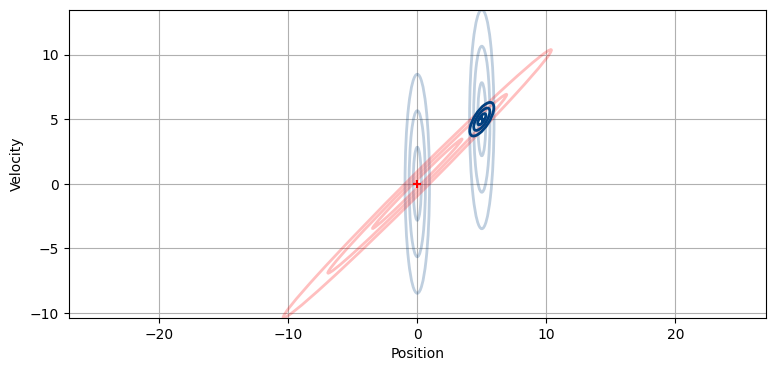

In [109]:
mkf_internal.show_x_error_chart(4)

The new covariance (the posterior) lies at the intersection of the position covariance and the velocity covariance. It is slightly tilted, showing that there is some correlation between the position and velocity. Far more importantly, it is much smaller than either the position or velocity covariances. In the previous chapter our variance would get smaller each time we performed an `update()` because the previous estimate was multiplied by the new measurement. The same happens here. However, here the improvement is markedly better. This is because we are using two different pieces of information which are nevertheless correlated. Knowing the velocity approximately and their correlation and the position approximately allows us to make a very accurate estimate. It is not easy to see in this diagram, but the uncertainty in position has become smaller. We know this because the new covariance doesn't reach as far in the x-axis as the measurement covariance at t=1. So we are not just more certain about velocity, but we are also more certain about the position than we would be if we only used position measurement without considering the velocity!

This is a key point, so read carefully! The radar is only detecting the position of the aircraft. This is called an *observed variable*. Based on the position estimates we can compute velocity. We call the velocity a *hidden variable*. Hidden means what it sounds like - there is no sensor that is measuring velocity, thus its value is hidden from us. We are able to use the correlation between position and velocity to infer its value very accurately.

To round out the terminology there are also *unobserved variables*. For example, the aircraft's state includes things such as as heading, engine RPM, weight, color, the first name of the pilot, and so on. We cannot sense these directly using the position sensor so they are not *observed*. There is no way to *infer* them from the sensor measurements and correlations (red planes don't go faster than white planes), so they are not *hidden*. Instead, they are *unobservable*. If you include an unobserved variable in your filter state the estimate for that variable will be nonsense.

What makes this possible? Imagine for a moment that we superimposed the velocity from a different airplane over the position graph. Clearly the two are not related, and there is no way that combining the two could possibly yield any additional information. In contrast, the velocity of this airplane tells us something very important - the direction and speed of travel. So long as the aircraft does not alter its velocity the velocity allows us to predict where the next position is. After a relatively small amount of error in velocity the probability that it is a good match with the position is very small. Think about it - if you suddenly change direction your position is also going to change a lot. If the measurement of the position is not in the direction of the velocity change it is very unlikely to be true. The two are correlated, so if the velocity changes so must the position, and in a predictable way. 

It is important to understand that we are taking advantage of the fact that velocity and position are correlated. We get a rough estimate of velocity from the distance and time between two measurements, and use Bayes theorem to produce very accurate estimates after only a few observations. Please reread this section if you have any doubts. If you do not understand this you will quickly find it impossible to reason about what you will learn in the following chapters.

The effect of including velocity appears to me minor if only care about the position. But this is only after one update. In the next chapter we will see what a dramatic increase in certainty we have after multiple updates. The measurment variance will be large, but the estimated position variance will be small. Each time you intersect the velocity covariance with position it gets narrower on the x-axis, hence the variance is also smaller each time.

## Higher Dimensions

So far I have shown you two dimensional Gaussians, but the math does not limit you to two dimensions. In later chapters we will be working in 9, or even 12 dimensions. If you work in areas such as weather prediction, you can end up with thousands of dimensions.

What do these higher dimensions 'look like? Well, a two dimensional Gaussian can be represented by an error ellipse, so it stands to reason a three dimensional Gaussian could be represented by a 3D error ellipsoid. We won't delve into the math here, but this turns out to be true. `FilterPy` provides a function to plot this ellipse.

First, let's make some noisy data with a given covariance, just so we can plot it inside the ellipsoid.

In [110]:
from filterpy.stats import plot_3d_covariance

mu = [0.3, 5., 10.]
C = np.array([[1.0, .03, .2],
              [.03,  4.0, .0],
              [.2,  .0, 16.1]])

sample = np.random.multivariate_normal(mu, C, size=1000)

Now we plot the ellipsoid with the `FilterPy` function `plot_3d_covariance`, and then scatter plot the samples.

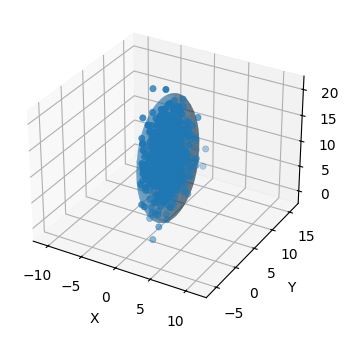

In [111]:
ax = plot_3d_covariance(mu, C, alpha=.4, std=3, limit_xyz=True)
ax.scatter(sample[:, 0], sample[:, 1], zs=sample[:, 2],);

Theory states that roughly 99% of a distribution will fall within 3 standard deviations, and this appears to be the case.

Nine dimensions? I haven't quite figured out how to plot a 9D ellipsoid on a 2D screen, so there will be no graphs. The concept is the same; the standard deviation error of the distribution can be described by a 9D ellipsoid.

## Summary

We have taken advantage of the geometry and correlations of the system to produce a very accurate estimate. The math does not care whether we are working with two positions, or a position and a correlated velocity, or if these are spatial dimensions. If floor space is correlated to house price you can write a Kalman filter to track house prices. If age is correlated to disease incidence you can write a Kalman filter to track diseases. If the zombie population is inversely correlated with the number of shotguns then you can write a Kalman filter to track zombie populations. I showed you this in terms of geometry and talked about *triangulation*. That was just to build your intuition. You can write a Kalman filter for state variables that have no geometric representation, such as filters for stock prices or milk production of cows (I received an email from someone tracking milk production!) Get used to thinking of these as Gaussians with correlations. If we can express our uncertainties as a multidimensional Gaussian we can then multiply the prior with the likelihood and get a much more accurate result. 

## References

- [1] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

- [2] `FilterPy` library. Roger Labbe.
https://github.com/rlabbe/filterpy